In [2]:
import dgl
import numpy as np
import pandas as pd
import torch

from dgl.data.utils import load_graphs, save_graphs

In [189]:
# !pip install dgl
# !pip install torch_geometric

### Convert to PyG

In [3]:
selected_nodes = pd.read_csv('data/tfinance/selected_nodes.csv')
selected_edges = pd.read_csv('data/tfinance/selected_edges.csv')
selected_labels = pd.read_csv('data/tfinance/selected_labels.csv')

In [4]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp
from torch_geometric.loader import DataLoader as pyg_DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(selected_nodes)
selected_nodes_scaled = pd.DataFrame(features_scaled, index=selected_nodes.index, columns=selected_nodes.columns)
selected_nodes_scaled

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
0,0.966892,-0.302345,-0.303793,-0.177117,-0.267849,-0.161530,-0.364640,-0.142817,-0.417713,-0.643477
1,1.975264,-0.182326,1.641039,0.465295,-0.268168,0.357262,-0.458247,0.386965,-0.894606,-0.848755
2,2.541011,-0.278478,0.016163,-0.102169,-0.228462,-0.019719,0.033190,-0.022844,-0.875343,-0.872905
3,-1.031149,-0.253015,-0.234783,-0.305600,-0.134698,-0.192256,-0.516752,-0.160635,-0.226134,-0.688734
4,-0.275260,-0.281746,-0.278698,-0.230652,-0.209167,-0.160348,-0.271033,-0.152320,-0.409034,-0.404129
...,...,...,...,...,...,...,...,...,...,...
14995,-0.480986,-0.303485,-0.146952,-0.123583,-0.269444,-0.144986,-0.446546,-0.117872,0.729831,1.183965
14996,-0.929844,0.330664,-0.297519,-0.252065,1.094280,-0.215891,-0.516752,-0.184392,-0.859675,-0.864036
14997,-0.540210,-0.197832,0.185552,-0.102169,-0.268965,0.040551,-0.411444,0.072184,-0.205254,-0.243863
14998,-0.845683,0.236032,-0.215962,-0.230652,-0.240421,-0.076443,-0.399743,-0.045413,0.264550,0.183068


In [6]:
edge_index = np.array(selected_edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long)
print(edge_index)

print("shape of edge index is {}".format(edge_index.shape))

node_features_t = torch.tensor(np.array(selected_nodes.values, dtype=np.double), dtype=torch.double)
data_graph = Data(x=node_features_t.float(), edge_index=edge_index,
                               y=torch.tensor(selected_labels.values.flatten(), dtype=torch.long))

node_features_scaled_t = torch.tensor(np.array(selected_nodes_scaled.values, dtype=np.double), dtype=torch.double)
data_graph_scaled = Data(x=node_features_scaled_t.float(), edge_index=edge_index,
                                 y=torch.tensor(selected_labels.values.flatten(), dtype=torch.long))

tensor([[12230, 12230, 12230,  ..., 10945, 10945, 10945],
        [ 6579,  8455,   272,  ...,  8153,  6480,  9753]])
shape of edge index is torch.Size([2, 6032438])


In [7]:
sample_size = 15000

train_idx = list(pd.read_csv('data/tfinance/index/train_idx.csv', names=['id']).values.flatten())
test_idx = list(pd.read_csv('data/tfinance/index/test_idx.csv', names=['id']).values.flatten())

data_graph.train_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph.train_idx[train_idx] = 1

data_graph.test_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph.test_idx[test_idx] = 1

data_graph_scaled.train_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph_scaled.train_idx[train_idx] = 1

data_graph_scaled.test_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph_scaled.test_idx[test_idx] = 1

### GCN

In [8]:
# 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda')

In [10]:
# CLASS_WEIGTHS = [0.7,0.3]

def train(model, data, optimizer, scheduler):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # out = out.reshape((data.x.shape[0]))
    # # use weighted cross entropy loss, weighted cross entropy loss to provide higher importance to the illicit samples.
    # weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    # loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx])
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        # metrics for illicit transactions
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu(), average='binary')
        precision = precision_score(y.cpu(), pred.cpu(), average='binary')
        recall = recall_score(y.cpu(), pred.cpu(), average='binary')
        auc = roc_auc_score(y.cpu(), pred_scores[:,1].cpu())
        return acc, f1, precision, recall, auc

In [11]:
num_features = data_graph.num_node_features
print("num_features=",num_features)

num_features= 10


In [96]:
model = GCN(num_features, 2).to(device)
num_epochs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph_scaled, optimizer, scheduler)
    acc, f1, precision, recall, roc = test(model, data_graph_scaled)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 0.6644, Accuracy: 0.8956, F1: 0.3974, Precision:  0.2748, Recall: 0.7176, ROC: 0.6940
Epoch: 010, Loss: 0.1534, Accuracy: 0.9713, F1: 0.6921, Precision:  0.7143, Recall: 0.6713, ROC: 0.9079
Epoch: 020, Loss: 0.1154, Accuracy: 0.9762, F1: 0.7147, Precision:  0.8428, Recall: 0.6204, ROC: 0.9159
Epoch: 030, Loss: 0.1134, Accuracy: 0.9769, F1: 0.7219, Precision:  0.8544, Recall: 0.6250, ROC: 0.9155
Epoch: 040, Loss: 0.1121, Accuracy: 0.9767, F1: 0.7287, Precision:  0.8246, Recall: 0.6528, ROC: 0.9143
Epoch: 050, Loss: 0.1098, Accuracy: 0.9773, F1: 0.7316, Precision:  0.8476, Recall: 0.6435, ROC: 0.9154
Epoch: 060, Loss: 0.1088, Accuracy: 0.9773, F1: 0.7302, Precision:  0.8519, Recall: 0.6389, ROC: 0.9161
Epoch: 070, Loss: 0.1081, Accuracy: 0.9773, F1: 0.7316, Precision:  0.8476, Recall: 0.6435, ROC: 0.9161
Epoch: 080, Loss: 0.1076, Accuracy: 0.9776, F1: 0.7349, Precision:  0.8485, Recall: 0.6481, ROC: 0.9163
Epoch: 090, Loss: 0.1070, Accuracy: 0.9776, F1: 0.7349, Precisio

### Random Forest

In [114]:
X_train = selected_nodes.loc[train_idx]
y_train = selected_labels.loc[train_idx]

X_test = selected_nodes.loc[test_idx]
y_test = selected_labels.loc[test_idx]

X_train_scaled = selected_nodes_scaled.loc[train_idx]
X_test_scaled = selected_nodes_scaled.loc[test_idx]

In [115]:
y_train.label.value_counts()

0    10000
1      500
Name: label, dtype: int64

In [116]:
y_test.label.value_counts()

0    4284
1     216
Name: label, dtype: int64

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train.reset_index(drop=True), y_train.reset_index(drop=True))

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc)

Accuracy:  0.9806666666666667
F1:        0.7679999999999999
Precision: 0.9056603773584906
Recall:    0.6666666666666666
ROC AUC:   0.9467835745409274


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True))

# Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc)

Accuracy:  0.9806666666666667
F1:        0.7679999999999999
Precision: 0.9056603773584906
Recall:    0.6666666666666666
ROC AUC:   0.5371148459383753


### GAT

In [15]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads, hidden_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [98]:
num_features = 10
num_classes = 2
num_heads = 1
hidden_dim = 128

model = GAT(num_features, num_classes, num_heads, hidden_dim).to(device)

num_epochs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph_scaled, optimizer, scheduler)
    acc, f1, precision, recall, roc = test(model, data_graph_scaled)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 0.6855, Accuracy: 0.9469, F1: 0.2060, Precision:  0.3647, Recall: 0.1435, ROC: 0.8380
Epoch: 010, Loss: 0.2026, Accuracy: 0.9356, F1: 0.0136, Precision:  0.0256, Recall: 0.0093, ROC: 0.8434
Epoch: 020, Loss: 0.1523, Accuracy: 0.9464, F1: 0.0082, Precision:  0.0370, Recall: 0.0046, ROC: 0.8877
Epoch: 030, Loss: 0.1283, Accuracy: 0.9540, F1: 0.1266, Precision:  0.7143, Recall: 0.0694, ROC: 0.9071
Epoch: 040, Loss: 0.1192, Accuracy: 0.9682, F1: 0.5402, Precision:  0.8842, Recall: 0.3889, ROC: 0.9150
Epoch: 050, Loss: 0.1168, Accuracy: 0.9731, F1: 0.6630, Precision:  0.8322, Recall: 0.5509, ROC: 0.9165
Epoch: 060, Loss: 0.1142, Accuracy: 0.9713, F1: 0.6149, Precision:  0.8655, Recall: 0.4769, ROC: 0.9175
Epoch: 070, Loss: 0.1124, Accuracy: 0.9722, F1: 0.6246, Precision:  0.8889, Recall: 0.4815, ROC: 0.9190
Epoch: 080, Loss: 0.1108, Accuracy: 0.9724, F1: 0.6242, Precision:  0.9035, Recall: 0.4769, ROC: 0.9182
Epoch: 090, Loss: 0.1096, Accuracy: 0.9744, F1: 0.6705, Precisio

## Identify fraud patterns in tfinance

In [17]:
selected_nodes = pd.read_csv('data/tfinance/selected_nodes.csv')
selected_edges = pd.read_csv('data/tfinance/selected_edges.csv')
selected_labels = pd.read_csv('data/tfinance/selected_labels.csv')

In [18]:
train_idx = list(pd.read_csv('data/tfinance/index/train_idx.csv', names=['id']).values.flatten())
test_idx = list(pd.read_csv('data/tfinance/index/test_idx.csv', names=['id']).values.flatten())

In [19]:
df_merge = pd.concat([selected_nodes_scaled, selected_labels], axis=1)
df_merge

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label
0,0.966892,-0.302345,-0.303793,-0.177117,-0.267849,-0.161530,-0.364640,-0.142817,-0.417713,-0.643477,0
1,1.975264,-0.182326,1.641039,0.465295,-0.268168,0.357262,-0.458247,0.386965,-0.894606,-0.848755,0
2,2.541011,-0.278478,0.016163,-0.102169,-0.228462,-0.019719,0.033190,-0.022844,-0.875343,-0.872905,0
3,-1.031149,-0.253015,-0.234783,-0.305600,-0.134698,-0.192256,-0.516752,-0.160635,-0.226134,-0.688734,0
4,-0.275260,-0.281746,-0.278698,-0.230652,-0.209167,-0.160348,-0.271033,-0.152320,-0.409034,-0.404129,0
...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.480986,-0.303485,-0.146952,-0.123583,-0.269444,-0.144986,-0.446546,-0.117872,0.729831,1.183965,0
14996,-0.929844,0.330664,-0.297519,-0.252065,1.094280,-0.215891,-0.516752,-0.184392,-0.859675,-0.864036,0
14997,-0.540210,-0.197832,0.185552,-0.102169,-0.268965,0.040551,-0.411444,0.072184,-0.205254,-0.243863,0
14998,-0.845683,0.236032,-0.215962,-0.230652,-0.240421,-0.076443,-0.399743,-0.045413,0.264550,0.183068,0


### Compute the illicit ratio of a node's one hop neighbors

In [20]:
for i in range(len(df_merge)):

    selected_node = df_merge.index[i]
    # filter the one hop edges
    one_hop_edge = selected_edges[(selected_edges.ID1 == selected_node)|(selected_edges.ID2 == selected_node)]

    # isolated node
    if one_hop_edge.empty:
        df_merge.at[i, 'illicit_ratio'] = 0
    else:
        # get the one hop neighbors
        neighbors = list(set(one_hop_edge.ID1.values.tolist() + one_hop_edge.ID2.values.tolist()))
        neighbors.remove(selected_node)

        df_merge.at[i, 'degree'] = len(neighbors)

        # value counts of the labels
        value_counts = df_merge.loc[neighbors].label.value_counts()

        if 1 not in value_counts.keys():
            illicit_ratio = 0
        else:
            illicit_ratio = df_merge.loc[neighbors].label.value_counts(normalize=True)[1]
        df_merge.at[i, 'illicit_ratio'] = illicit_ratio

        if i % 1000 == 0:
            print(f"The illicit ratio of {selected_node}'s one hop neighbors is {illicit_ratio:.2f}")

The illicit ratio of 0's one hop neighbors is 0.00
The illicit ratio of 1000's one hop neighbors is 0.04
The illicit ratio of 2000's one hop neighbors is 0.01
The illicit ratio of 3000's one hop neighbors is 0.00
The illicit ratio of 4000's one hop neighbors is 0.00
The illicit ratio of 5000's one hop neighbors is 0.01
The illicit ratio of 6000's one hop neighbors is 0.17
The illicit ratio of 7000's one hop neighbors is 0.00
The illicit ratio of 8000's one hop neighbors is 0.01
The illicit ratio of 9000's one hop neighbors is 0.04
The illicit ratio of 10000's one hop neighbors is 0.01
The illicit ratio of 11000's one hop neighbors is 0.00
The illicit ratio of 12000's one hop neighbors is 0.04
The illicit ratio of 13000's one hop neighbors is 0.79
The illicit ratio of 14000's one hop neighbors is 0.00


In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_anomaly_graph(edge_df):

    graph = nx.from_pandas_edgelist(edge_df, source='ID1', target='ID2')
    pos = nx.spring_layout(graph)

    class_labels = {}
    for node in graph.nodes():
        # label = res[res.txId == node]['label'].values[0]
        label = df_merge[df_merge.index == node]['label'].values[0]
        class_labels[node] = label
    class_colors = {1: 'red', 0: 'blue', 2: 'green'}
    node_colors = [class_colors[class_labels[node]] for node in graph.nodes()]
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx(graph, with_labels=False, pos=pos, node_color=node_colors)
    # nx.draw_networkx(graph, with_labels=False, node_color=node_colors)

    plt.show()

In [22]:
# Sort the dataframe by 'ratio' column in descending order
df_ratio_sorted = df_merge.sort_values(by='illicit_ratio', ascending=False)
df_ratio_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,degree,illicit_ratio
10708,-0.766198,-0.321955,-0.316340,-0.294893,-0.273590,-0.221800,-0.528452,-0.189144,-1.114165,-0.898296,1,35.0,1.0
3558,-1.018680,-0.218734,-0.178320,-0.305600,-0.129754,-0.194619,-0.516752,-0.161823,1.602780,2.150146,0,2.0,1.0
4858,-0.791134,-0.321955,-0.316340,-0.294893,-0.273590,-0.221800,-0.528452,-0.189144,-1.105276,-0.892393,1,35.0,1.0
13657,-0.805161,-0.321727,-0.316340,-0.273479,-0.273590,-0.220618,-0.528452,-0.187956,-1.142695,-0.888551,1,35.0,1.0
11316,-0.773990,-0.321651,-0.316340,-0.294893,-0.273590,-0.220618,-0.528452,-0.187956,-1.149936,-0.896565,1,35.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,-0.381240,-0.005907,0.022437,0.047727,-0.256049,0.086639,-0.446546,0.118510,-0.858470,-0.767125,0,9.0,0.0
10402,-0.284611,-0.314430,-0.297519,-0.284186,-0.265617,-0.152076,-0.341238,-0.134502,1.934668,2.401813,0,17.0,0.0
10401,-0.956339,-0.298772,-0.310066,-0.294893,-0.260035,-0.212346,-0.493350,-0.179641,-0.819703,-0.776330,0,9.0,0.0
10400,-0.678920,-0.305993,-0.159499,0.111968,-0.273590,-0.134350,-0.528452,-0.101242,-0.765683,-0.865633,0,63.0,0.0


In [23]:
# Sort the sorted dataframe by 'degree' column in descending order
df_degree_sorted = df_merge.sort_values(by='degree', ascending=False)
df_degree_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,degree,illicit_ratio
168,6.717882,1.833147,0.750181,1.514567,2.867344,0.943415,5.684716,0.549701,-0.156261,-0.311425,0,2822.0,0.010276
12560,2.667253,-0.238497,-0.034026,0.101261,-0.181899,0.015734,0.419319,-0.021656,-0.223256,-0.539823,0,2756.0,0.014877
2687,0.709734,0.592593,0.053805,-0.144997,1.451636,0.046460,1.413894,-0.092927,-0.988842,-0.788853,1,2735.0,0.111517
9494,1.992407,0.168839,0.279657,0.186916,0.021575,0.588887,1.320287,0.508126,-0.745194,-0.785179,0,2730.0,0.018315
6544,6.610344,0.643216,0.994853,1.386085,0.066703,0.893782,2.583982,0.767077,-0.252269,0.010416,0,2724.0,0.011013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13937,-0.956339,-0.266924,-0.303793,-0.305600,-0.199759,-0.179257,-0.142323,-0.153508,1.894888,2.228186,0,NaN,0.000000
14203,-0.998419,-0.319751,-0.310066,-0.305600,-0.270241,-0.208801,-0.411444,-0.182016,1.932876,2.515498,0,NaN,0.000000
14332,-1.031149,-0.264416,-0.303793,-0.091462,-0.243770,-0.187529,-0.423144,-0.154696,1.981945,1.483627,0,NaN,0.000000
14941,-1.009329,-0.295960,-0.310066,-0.294893,-0.219213,-0.201710,-0.329537,-0.189144,2.227287,1.890944,0,NaN,0.000000


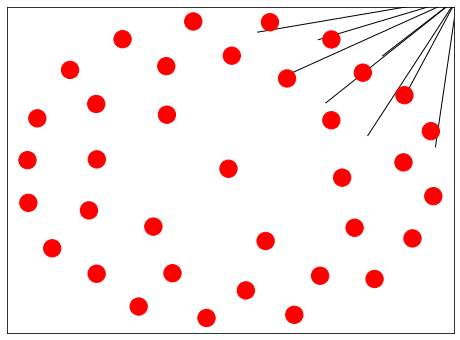

In [24]:
selected_node = df_ratio_sorted.index[0]
one_hop_edge = selected_edges[(selected_edges.ID1 == selected_node)|(selected_edges.ID2 == selected_node)]
visualize_anomaly_graph(one_hop_edge)

### Remove the top nodes from the training set, and also the edges

#### Sort according to ratio

In [25]:
df_train_ratio_sorted = df_merge.loc[train_idx].sort_values(by='illicit_ratio', ascending=False)
df_train_ratio_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,degree,illicit_ratio
13950,-0.830098,-0.321803,-0.316340,-0.284186,-0.273590,-0.220618,-0.528452,-0.187956,-1.135443,-0.907110,1,35.0,1.0
675,-0.763081,-0.321955,-0.316340,-0.294893,-0.273590,-0.221800,-0.528452,-0.189144,-1.115169,-0.898963,1,35.0,1.0
972,-0.819188,-0.321727,-0.316340,-0.284186,-0.273590,-0.220618,-0.528452,-0.187956,-1.138806,-0.909591,1,35.0,1.0
11761,-0.725676,-0.321727,-0.316340,-0.262772,-0.273590,-0.220618,-0.528452,-0.187956,-1.174790,-0.942176,1,35.0,1.0
4302,-0.985951,-0.148349,-0.310066,-0.305600,-0.091802,-0.207619,-0.411444,-0.183204,0.629711,0.365871,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-0.844124,-0.313898,-0.316340,-0.262772,-0.258600,-0.208801,-0.493350,-0.179641,0.432994,0.855425,0,9.0,0.0
12532,-0.273701,-0.202088,-0.203414,-0.209238,-0.144106,-0.121350,-0.165725,-0.109557,-0.293848,-0.009872,0,77.0,0.0
1815,-0.861268,-0.282582,-0.291246,-0.305600,-0.259398,-0.110715,-0.282734,-0.079861,0.244604,0.646914,0,3.0,0.0
3543,-0.602552,-0.305537,-0.247330,-0.262772,-0.265457,-0.142622,-0.317837,-0.123812,1.942045,2.354638,0,3.0,0.0


#### Sort according to ratio and degree with a weighted score

In [85]:
ratio_weight  = 0.9
degree_weight = 0.1
df_merge['degree_norm'] = normalized_column = (df_merge['degree'] - df_merge['degree'].min()) / (df_merge['degree'].max() - df_merge['degree'].min())
df_merge['weighted_score'] = df_merge['illicit_ratio'] * ratio_weight + df_merge['degree_norm'] * degree_weight
df_merge

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,degree,illicit_ratio,degree_norm,weighted_score
0,0.966892,-0.302345,-0.303793,-0.177117,-0.267849,-0.161530,-0.364640,-0.142817,-0.417713,-0.643477,0,124.0,0.000000,0.043602,0.004360
1,1.975264,-0.182326,1.641039,0.465295,-0.268168,0.357262,-0.458247,0.386965,-0.894606,-0.848755,0,2197.0,0.009558,0.778447,0.086447
2,2.541011,-0.278478,0.016163,-0.102169,-0.228462,-0.019719,0.033190,-0.022844,-0.875343,-0.872905,0,2121.0,0.009430,0.751507,0.083637
3,-1.031149,-0.253015,-0.234783,-0.305600,-0.134698,-0.192256,-0.516752,-0.160635,-0.226134,-0.688734,0,10.0,0.000000,0.003190,0.000319
4,-0.275260,-0.281746,-0.278698,-0.230652,-0.209167,-0.160348,-0.271033,-0.152320,-0.409034,-0.404129,0,52.0,0.000000,0.018079,0.001808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.480986,-0.303485,-0.146952,-0.123583,-0.269444,-0.144986,-0.446546,-0.117872,0.729831,1.183965,0,88.0,0.022727,0.030840,0.023539
14996,-0.929844,0.330664,-0.297519,-0.252065,1.094280,-0.215891,-0.516752,-0.184392,-0.859675,-0.864036,0,3.0,0.000000,0.000709,0.000071
14997,-0.540210,-0.197832,0.185552,-0.102169,-0.268965,0.040551,-0.411444,0.072184,-0.205254,-0.243863,0,32.0,0.000000,0.010989,0.001099
14998,-0.845683,0.236032,-0.215962,-0.230652,-0.240421,-0.076443,-0.399743,-0.045413,0.264550,0.183068,0,30.0,0.000000,0.010280,0.001028


In [86]:
df_train_weight_sorted = df_merge.loc[train_idx].sort_values(by='weighted_score', ascending=False)
df_train_weight_sorted

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,label,degree,illicit_ratio,degree_norm,weighted_score
4858,-0.791134,-0.321955,-0.316340,-0.294893,-0.273590,-0.221800,-0.528452,-0.189144,-1.105276,-0.892393,1,35.0,1.0,0.012052,0.901205
972,-0.819188,-0.321727,-0.316340,-0.284186,-0.273590,-0.220618,-0.528452,-0.187956,-1.138806,-0.909591,1,35.0,1.0,0.012052,0.901205
2577,-0.780225,-0.321727,-0.316340,-0.273479,-0.273590,-0.220618,-0.528452,-0.187956,-1.168247,-0.916832,1,35.0,1.0,0.012052,0.901205
8912,-0.778666,-0.321575,-0.316340,-0.273479,-0.273590,-0.219436,-0.528452,-0.186768,-1.148954,-0.895479,1,35.0,1.0,0.012052,0.901205
11870,-0.769315,-0.321955,-0.316340,-0.294893,-0.273590,-0.221800,-0.528452,-0.189144,-1.113140,-0.897615,1,35.0,1.0,0.012052,0.901205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,-0.918934,-0.011684,-0.241056,-0.294893,-0.273271,-0.144986,-0.516752,-0.111933,1.748014,2.178277,0,NaN,0.0,NaN,NaN
12536,-1.003095,-0.277642,-0.291246,-0.305600,-0.197367,-0.202892,-0.376341,-0.178453,1.475927,1.415740,0,NaN,0.0,NaN,NaN
2923,-0.943871,12.651604,0.122816,-0.305600,-0.272792,-0.113078,-0.481649,-0.079861,-0.373339,-0.417189,0,NaN,0.0,NaN,NaN
12289,-1.029590,-0.297480,-0.316340,-0.294893,-0.232767,-0.208801,-0.411444,-0.180829,1.769315,2.334468,0,NaN,0.0,NaN,NaN


In [172]:
nodes_to_remove = df_train_weight_sorted.index[:50].tolist()

In [173]:
print('Number of edges before mask: ', len(selected_edges))
selected_edges_filtered = selected_edges[~selected_edges['ID1'].isin(nodes_to_remove) & ~selected_edges['ID2'].isin(nodes_to_remove)]
print('Number of edges after  mask: ', len(selected_edges_filtered))

Number of edges before mask:  6032438
Number of edges after  mask:  6026522


In [174]:
edge_index_filtered = np.array(selected_edges_filtered.values).T 
edge_index_filtered = torch.tensor(edge_index_filtered, dtype=torch.long)
print(edge_index_filtered)

print("shape of edge index filtered is {}".format(edge_index_filtered.shape))

node_features_scaled_filtered_t = torch.tensor(np.array(selected_nodes_scaled.values, dtype=np.double), dtype=torch.double)
data_graph_scaled_filtered = Data(x=node_features_scaled_filtered_t.float(), edge_index=edge_index_filtered,
                         y=torch.tensor(selected_labels.values.flatten(), dtype=torch.long))

tensor([[12230, 12230, 12230,  ..., 10945, 10945, 10945],
        [ 6579,  8455,   272,  ...,  8153,  6480,  9753]])
shape of edge index filtered is torch.Size([2, 6026522])


In [175]:
selected_labels.label.value_counts()

0    14284
1      716
Name: label, dtype: int64

In [176]:
sample_size = 15000

data_graph_scaled_filtered.train_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph_scaled_filtered.train_idx[train_idx] = 1
print('Number of trains before mask: ', data_graph_scaled_filtered.train_idx.sum())
data_graph_scaled_filtered.train_idx[nodes_to_remove] = 0
print('Number of trains after mask: ', data_graph_scaled_filtered.train_idx.sum())

data_graph_scaled_filtered.test_idx = torch.zeros(sample_size, dtype=torch.bool)
data_graph_scaled_filtered.test_idx[test_idx] = 1

Number of trains before mask:  tensor(10500)
Number of trains after mask:  tensor(10450)


#### Train GCN with top nodes masked

In [177]:
model = GCN(num_features, 2, hidden_channels=256).to(device)
num_epochs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph_scaled_filtered, optimizer, scheduler)
    acc, f1, precision, recall, roc = test(model, data_graph_scaled_filtered)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 0.7336, Accuracy: 0.8962, F1: 0.0251, Precision:  0.0228, Recall: 0.0278, ROC: 0.6637
Epoch: 010, Loss: 0.1299, Accuracy: 0.9733, F1: 0.6739, Precision:  0.8158, Recall: 0.5741, ROC: 0.9094
Epoch: 020, Loss: 0.1224, Accuracy: 0.9747, F1: 0.7121, Precision:  0.7833, Recall: 0.6528, ROC: 0.9149
Epoch: 030, Loss: 0.1147, Accuracy: 0.9764, F1: 0.7240, Precision:  0.8274, Recall: 0.6435, ROC: 0.9127
Epoch: 040, Loss: 0.1119, Accuracy: 0.9764, F1: 0.7166, Precision:  0.8481, Recall: 0.6204, ROC: 0.9135
Epoch: 050, Loss: 0.1095, Accuracy: 0.9762, F1: 0.7116, Precision:  0.8516, Recall: 0.6111, ROC: 0.9152
Epoch: 060, Loss: 0.1088, Accuracy: 0.9764, F1: 0.7151, Precision:  0.8526, Recall: 0.6157, ROC: 0.9154
Epoch: 070, Loss: 0.1082, Accuracy: 0.9769, F1: 0.7234, Precision:  0.8500, Recall: 0.6296, ROC: 0.9155
Epoch: 080, Loss: 0.1074, Accuracy: 0.9771, F1: 0.7282, Precision:  0.8466, Recall: 0.6389, ROC: 0.9156
Epoch: 090, Loss: 0.1068, Accuracy: 0.9769, F1: 0.7249, Precisio

#### Train GAT with top nodes masked

In [178]:
torch.count_nonzero(data_graph_scaled_filtered.y[data_graph_scaled_filtered.train_idx])

tensor(453, device='cuda:0')

In [179]:
num_features = 10
num_classes = 2
num_heads = 1
hidden_dim = 128

model = GAT(num_features, num_classes, num_heads, hidden_dim).to(device)

num_epochs = 1000
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph_scaled_filtered, optimizer, scheduler)
    acc, f1, precision, recall, roc = test(model, data_graph_scaled_filtered)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision: .4f}, Recall: {recall:.4f}, ROC: {roc:.4f}')

Epoch: 000, Loss: 0.6226, Accuracy: 0.9460, F1: 0.1763, Precision:  0.3291, Recall: 0.1204, ROC: 0.6606
Epoch: 010, Loss: 0.1770, Accuracy: 0.9496, F1: 0.0340, Precision:  0.2105, Recall: 0.0185, ROC: 0.8019
Epoch: 020, Loss: 0.1626, Accuracy: 0.9518, F1: 0.0269, Precision:  0.4286, Recall: 0.0139, ROC: 0.7923
Epoch: 030, Loss: 0.1450, Accuracy: 0.9627, F1: 0.5030, Precision:  0.6967, Recall: 0.3935, ROC: 0.8565
Epoch: 040, Loss: 0.1311, Accuracy: 0.9647, F1: 0.5714, Precision:  0.6839, Recall: 0.4907, ROC: 0.8626
Epoch: 050, Loss: 0.1236, Accuracy: 0.9689, F1: 0.6216, Precision:  0.7468, Recall: 0.5324, ROC: 0.8698
Epoch: 060, Loss: 0.1155, Accuracy: 0.9722, F1: 0.6499, Precision:  0.8227, Recall: 0.5370, ROC: 0.8805
Epoch: 070, Loss: 0.1114, Accuracy: 0.9744, F1: 0.6866, Precision:  0.8344, Recall: 0.5833, ROC: 0.8923
Epoch: 080, Loss: 0.1088, Accuracy: 0.9762, F1: 0.7068, Precision:  0.8658, Recall: 0.5972, ROC: 0.8985
Epoch: 090, Loss: 0.1069, Accuracy: 0.9771, F1: 0.7209, Precisio

#### Train Random Forest train_idx with top nodes masked

In [180]:
train_idx_removed = [x for x in train_idx if x not in nodes_to_remove]
len(train_idx_removed)

10450

In [181]:
X_train = selected_nodes.loc[train_idx_removed]
y_train = selected_labels.loc[train_idx_removed]

X_test = selected_nodes.loc[test_idx]
y_test = selected_labels.loc[test_idx]

In [182]:
rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train.reset_index(drop=True), y_train.reset_index(drop=True))

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc)

Accuracy:  0.98
F1:        0.7606382978723405
Precision: 0.89375
Recall:    0.6620370370370371
ROC AUC:   0.9439219360583739


### Results

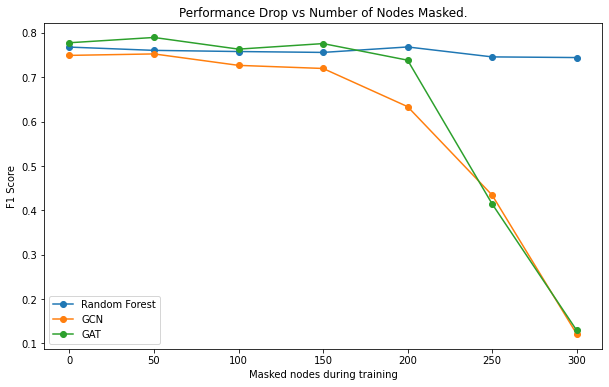

In [188]:
plt.figure(figsize=(10, 6))

rf = [0.7680, 0.7606, 0.7580, 0.7560, 0.7683, 0.7459, 0.7444]
gcn = [0.7493, 0.7526, 0.7268, 0.7198, 0.6337, 0.4342, 0.1212]
gat = [0.7778, 0.7897, 0.7634, 0.7759, 0.7385, 0.4143, 0.1293]

x = [0, 50, 100, 150, 200, 250, 300]

plt.plot(x, rf, '-o', label='Random Forest')
plt.plot(x, gcn,'-o',  label='GCN')
plt.plot(x, gat, '-o', label='GAT')

plt.xlabel('Masked nodes during training')
plt.xticks([0, 50, 100, 150, 200, 250, 300])
plt.ylabel('F1 Score')
plt.title('Performance vs Number of Nodes Masked.')
plt.legend(loc='lower left')